In [1]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
file = pd.read_csv('./files/times.dat', sep=r'\s+', names=['L', 'MCTOT', 'Temp', 'T'])

def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y


popt, pcov = curve_fit(func, (file['L'], file['MCTOT']), file['T'])


array([ 6.31402952e+01, -3.06071489e+00, -8.82913318e-03,  2.78081184e-02,
        2.31283434e-07,  2.26054704e-04])

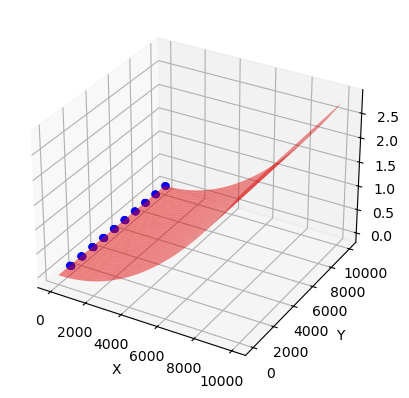

np.float64(114994.9359061495)

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(file['L'], file['MCTOT'], file['T'], color='blue')
x_range = np.linspace(0, 10000, 50)
y_range = np.linspace(0, 10000, 50)
X, Y = np.meshgrid(x_range, y_range)
Z = func((X, Y), *popt)
ax.plot_surface(X, Y, Z, color='red', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

func((2048, 10000), *popt)

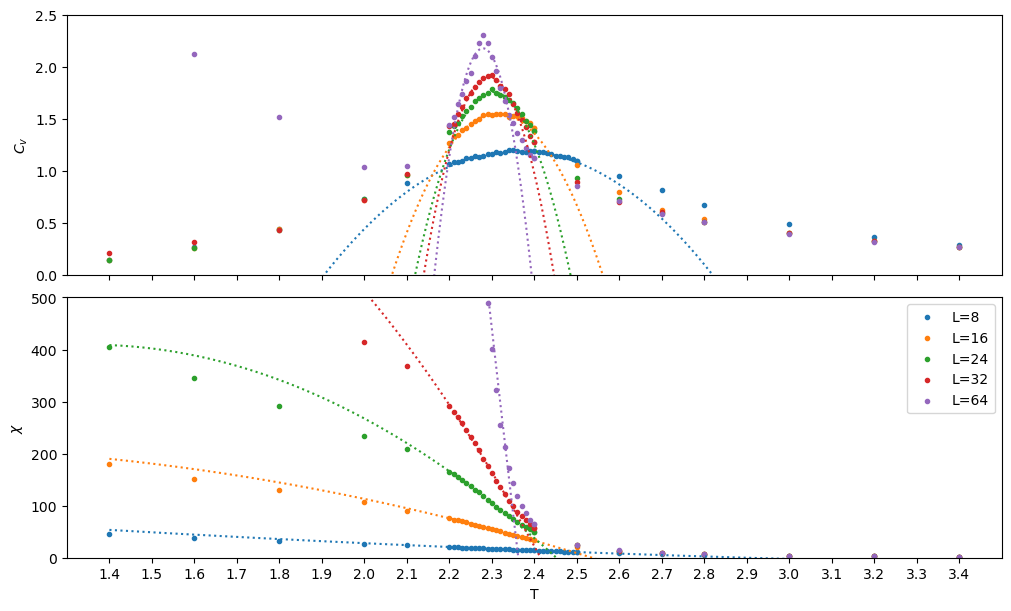

In [181]:
import warnings
warnings.filterwarnings('ignore')
df = pd.DataFrame(columns=["L", "T", "SUM", "<E>", "<E^2>", "Var E", "<M>", "<|M|>", "<M^2>", "Var M"])
dfs = []
files = [8, 16, 24, 32, 64]
for l in files:
    dfs.append(pd.read_csv(f"./files/stats-{l:3d}-2.dat", skiprows=1, sep=r'\s+', names=df.columns).sort_values("T"))

df = pd.concat(dfs, ignore_index=True)
# (($5-$4*$4)/($2*$2*$1*$1))
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,6), layout='constrained', sharex='col')

Xfit = np.linspace(1.4, 3.4, 1000)
cv_fits = {}
chi_fits = {}
deg = 2

for l in files:
    data = df[(df["L"] == l)]
    X = data["T"]
    Y = (data["<E^2>"]-data["<E>"]**2)/(data["T"]**2*data["L"]**2)
    reduced_data = data[(df["T"] >= 2.25) & (df["T"] <= (2.35 if l != 8 else 2.4))]
    red_X = reduced_data["T"]
    red_Y = (reduced_data["<E^2>"]-reduced_data["<E>"]**2)/(reduced_data["T"]**2*reduced_data["L"]**2)
    fit = np.polynomial.Polynomial.fit(red_X, red_Y, deg=deg)
    cv_fits[l] = (fit)
    # display(data)
    ax1.plot(Xfit, fit(Xfit), linestyle=':')
    ax1.scatter(X, Y, label=f"L={l}", marker='.')

for l in files:
    data = df[(df["L"] == l)]
    X = data["T"]
    Y = (data["<M^2>"]-data["<M>"]**2)/(data["T"]*data["L"]**2)
    reduced_data = data[(df["T"] >= 2.2) & (df["T"] <= (2.35 if l != 8 else 2.4))]
    red_X = reduced_data["T"]
    red_Y = (reduced_data["<M^2>"]-reduced_data["<M>"]**2)/(reduced_data["T"]*reduced_data["L"]**2)
    fit = np.polynomial.Polynomial.fit(red_X, red_Y, deg=deg)
    chi_fits[l] = (fit)
    # display(data)
    ax2.plot(Xfit, fit(Xfit), linestyle=':')
    ax2.scatter(X, Y, label=f"L={l}", marker='.')


ax2.set_xticks([x/10 for x in range(14, 35)])

# ax.set_xlim(2.2, 2.4)
ax1.set_ylim(0, 2.5)
ax2.set_ylim(0, 500)
# ax1.legend()
ax1.set_ylabel("$C_v$")
# ax1.set_xlabel("T")

ax2.legend()
ax2.set_ylabel("$\\chi$")
ax2.set_xlabel("T")

plt.show()


In [182]:
def find_extrema(poly, bounds):
    deriv = poly.deriv()
    extrema = deriv.roots()
    # Filter out complex roots
    extrema = extrema[np.isreal(extrema)]
    # Get real part of root
    extrema = np.real(extrema)
    # Apply bounds check
    lb, ub = bounds
    extrema = extrema[(lb <= extrema) & (extrema <= ub)]
    return extrema

def find_minimum(poly, bounds):
    extrema = find_extrema(poly, bounds)
    # Note: initially I tried taking the 2nd derivative to filter out local maxima.
    # This ended up being slower than just evaluating the function.

    # Either bound could end up being the minimum. Check those too.
    extrema = np.concatenate((extrema, bounds))
    # Check every candidate by evaluating the polynomial at each possible minimum,
    # and picking the minimum.
    value_at_extrema = poly(extrema)
    minimum_index = np.argmax(value_at_extrema)
    return extrema[minimum_index]


cv_maxs = {k: find_minimum(poly, (2.2, 2.5)) for k, poly in cv_fits.items()}

table = '[$L$], [$T_c$], [$C_v (T_c)$], [$chi(T_c)$], \n'
for k, t_c in cv_maxs.items():
    table += f'[{k}], [#num("{round(t_c, 3)}")], [#num("{round(cv_fits[k](t_c), 3)}")], [#num("{round(chi_fits[k](t_c), 3)}")],\n'

print(table)

[$L$], [$T_c$], [$C_v (T_c)$], [$chi(T_c)$], 
[8], [#num("2.363")], [#num("1.192")], [#num("15.14")],
[16], [#num("2.313")], [#num("1.552")], [#num("52.127")],
[24], [#num("2.302")], [#num("1.76")], [#num("103.846")],
[32], [#num("2.293")], [#num("1.903")], [#num("173.884")],
[64], [#num("2.279")], [#num("2.178")], [#num("593.066")],

